<a href="https://colab.research.google.com/github/bbenip/tetris-ai/blob/main/model/rl/rl_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/bbenip/tetris-ai.git tetris-ai
%ls

Cloning into 'tetris-ai'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 192 (delta 37), reused 39 (delta 10), pack-reused 93
Receiving objects: 100% (192/192), 36.49 MiB | 31.19 MiB/s, done.
Resolving deltas: 100% (69/69), done.
drive/  sample_data/  tetris-ai/


In [3]:
%cd tetris-ai/model/rl

/content/tetris-ai/model/rl


In [4]:
!git pull

Already up to date.


In [44]:
# @title Training Constants
NUM_EPISODES = 2048 # @param {type:"integer"}
MAX_MOVES = 1024 # @param {type:"integer"}
BATCH_SIZE = 1024 # @param {type:"integer"}
DISCOUNT_FACTOR = 1 # @param {type:"slider", min:0, max:1, step:0.01}
EXPLORATION_START = 0.3 # @param {type:"slider", min:0, max:1, step:0.1}
EXPLORATION_END = 0.3 # @param {type:"slider", min:0, max:1, step:0.1}
E_DECAY_STEPS = 2048 # @param {type:"integer"}
LEARNING_RATE = 0.001 # @param {type:"number"}

EPISODES_PER_UPDATE = 150 # @param {type:"integer"}

INVALID_MOVE_REWARD = -999 # @param {type:"integer"}
GAME_OVER_REWARD = -999 # @param {type:"integer"}
VALID_MOVE_REWARD = 1 # @param {type:"integer"}


In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, InputLayer

In [27]:
def create_model():
  # Define the input for the CNN branch
  board_input = Input(shape=(21, 10, 1), name='board_input')
  current_piece_input = Input(shape=(4, 4, 1), name='current_piece_input')
  next_piece_input = Input(shape=(4, 4, 1), name='next_piece_input')
  position_input = Input(shape=(2), name="position_input")

  # Create the CNN branch
  board_branch = Conv2D(256, (3, 3), activation='relu')(board_input)
  board_branch = MaxPooling2D((2, 2), padding='same')(board_branch)
  board_branch = Conv2D(32, (3, 3), activation='relu')(board_branch)
  board_branch = MaxPooling2D((2, 2), padding='same')(board_branch)
  board_branch = Flatten()(board_branch)

  current_branch = Conv2D(32, (3, 3), activation='relu')(current_piece_input)
  current_branch = Flatten()(current_branch)

  next_branch = Conv2D(32, (3, 3), activation='relu')(next_piece_input)
  next_branch = Flatten()(next_branch)

  # Concatenate the 3 branches + position
  concatenated_inputs = concatenate([board_branch,
                                     current_branch,
                                     next_branch,
                                     position_input],
                                    name='concatenated_inputs')

  # Create the dense branch for the concatenated inputs
  dense_branch = Dense(64, activation='relu')(concatenated_inputs)
  dense_branch = Dense(64, activation='relu')(dense_branch)
  dense_branch = Dense(32, activation='relu')(dense_branch)
  dense_branch = Dense(32, activation='relu')(dense_branch)

  # Create the output layer
  output = Dense(6, activation='linear', name='output')(dense_branch)

  # Define the model with 4 inputs and one output
  model = tf.keras.Model(inputs=[board_input,
                                 current_piece_input,
                                 next_piece_input,
                                 position_input],
                         outputs=output)

  # Define the optimizer and loss function based on your RL task.
  optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)  # Adjust the learning rate as needed.
  loss_fn = tf.keras.losses.MeanSquaredError()  # Adjust the loss function as needed.

  # Compile the model.
  model.compile(optimizer=optimizer, loss=loss_fn)

  return model

In [28]:
from random import sample
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = sample(range(self.size), batch_size)
        return [self.buffer[index] for index in indices]

In [ ]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output

def dqn(env,
        num_episodes,
        pretrained_model=None,
        batch_size=BATCH_SIZE,
        gamma=DISCOUNT_FACTOR,
        ε_start=EXPLORATION_START,
        ε_end=EXPLORATION_END,
        ε_decay_steps=E_DECAY_STEPS,
        learning_rate=LEARNING_RATE):
    replay_buffer = ReplayMemory(max_size=10000)
    model = pretrained_model if pretrained_model else create_model()  # Define the DQN neural network.
    target_model =  pretrained_model if pretrained_model else create_model()  # Target network for stability.

    current_step = 0
    scores = np.zeros(NUM_EPISODES)
    move_counts = np.zeros(NUM_EPISODES)
    avg_past_ten = np.zeros(NUM_EPISODES // EPISODES_PER_UPDATE + 1)

    for episode in range(NUM_EPISODES):
        score = 0
        moves = 0
        count = 0

        env.start_game()
        state = env.getState()
        done = False
        while not done and moves < MAX_MOVES:
          if current_step < ε_decay_steps:
            # Update epsilon using linear decay
            epsilon = max(ε_end, ε_start - (ε_start - ε_end) * (current_step / ε_decay_steps))

          # Epsilon-greedy action selection
          if np.random.rand() < epsilon:
              action = np.random.randint(6)  # Explore
              #print(f"Random Action: {action}")
          else:
              model_input = state
              model_input[0] = tf.reshape(model_input[0], (1, 21, 10, 1))
              model_input[1] = tf.reshape(model_input[1], (1, 4, 4, 1))
              model_input[2] = tf.reshape(model_input[2], (1, 4, 4, 1))
              action = np.argmax(model(model_input))
              #print(f"Action: {action}")

          next_state, reward, done = env.doAction(action)
          score += reward if reward > 0 else 0
          replay_buffer.append((state, action, reward, next_state, done))
          state = next_state

          count += 1
          moves += 1
          # Sample and train on mini-batch from replay buffer
          if replay_buffer.size >= batch_size and count > batch_size:
              count = 0
              mini_batch = replay_buffer.sample(batch_size)
              train_dqn(model, target_model, mini_batch, gamma, learning_rate)
        current_step += 1
        scores[episode] = score
        move_counts[episode] = moves
        avg_past_ten[episode // EPISODES_PER_UPDATE] = np.average(scores[episode-10:episode])
        if episode and episode % EPISODES_PER_UPDATE == 0:
            #clear_output(wait=True)
            print(f"Episode: {episode} \nAverage Score (Past 10 games): {avg_past_ten[episode // EPISODES_PER_UPDATE]}")
            fig, ax1 = plt.subplots()

            color = 'tab:red'
            ax1.set_xlabel('Episode')
            ax1.set_ylabel('Score', color=color)
            ax1.scatter(range(episode), scores[:episode], color=color)
            ax1.plot(range(0, episode, EPISODES_PER_UPDATE), avg_past_ten[:episode // EPISODES_PER_UPDATE], color="black", linewidth=2, label='moving_avg')
            ax1.tick_params(axis='y', labelcolor=color)

            ax2 = plt.subplot(312, sharex=ax1)
            ax2.plot(range(episode), move_counts[:episode], color="blue", label="score")

            fig.tight_layout()  # otherwise the right y-label is slightly clipped
            plt.show()

        if episode % (EPISODES_PER_UPDATE * 2) == 0:
            model.save("./model")


In [38]:
import numpy as np
import tensorflow as tf

def train_dqn(model, target_model, mini_batch, gamma, learning_rate):
    # Step 1: Compute the target Q-values using the target model
    states, actions, rewards, next_states, dones = zip(*mini_batch)

    target_q_values = []
    states_iter = zip(next_states, rewards, dones)
    for next_state, reward, done in states_iter:
        if done:
            target_q_values.append(rewards)  # If it's a terminal state, the Q-value is the immediate reward.
        else:
            # Use the target model to predict Q-values for the next state and select the maximum Q-value.
            next_state[0] = tf.reshape(next_state[0], (1, 21, 10, 1))
            next_state[1] = tf.reshape(next_state[1], (1, 4, 4, 1))
            next_state[2] = tf.reshape(next_state[2], (1, 4, 4, 1))
            max_q_value = np.max(model(next_state)[0])
            target_q = rewards + gamma * max_q_value
            target_q_values.append(target_q)

    target_q_values = np.array(target_q_values)

    # Step 2: Compute the predicted Q-values for the current states using the model
    model_inputs = np.dstack(states)
    print("Curr pieces ", model_inputs[1].shape)
    print("Boards ", model_inputs[0].shape)
    print("Targets ", target_q_values.shape)

    # Step 3: Calculate the target Q-values for the mini-batch
    target_q_values = np.expand_dims(target_q_values, axis=1)  # Add an extra dimension for broadcasting

    masks = tf.one_hot(actions, 6)

    # Step 5: Update the model's weights using gradient descent to minimize the loss
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    predicted_q_values = model(model_inputs)
    with tf.GradientTape() as tape:
        #predicted_q_values = tf.reduce_sum(tf.multiply(predicted_q_values, masks), axis=1)
        loss = tf.keras.losses.mean_squared_error(target_q_values, predicted_q_values)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss.numpy().mean()


In [34]:
pre_model = None

In [43]:
pre_model = tf.keras.models.load_model("./model")

Episode: 900 
Average Score (Past 10 games): 517.1


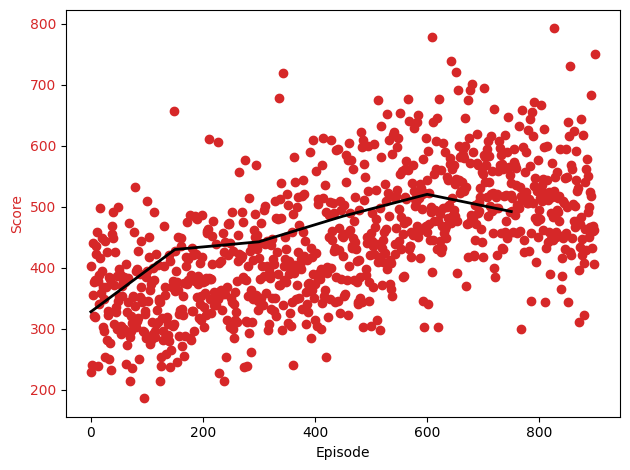

In [ ]:
from tetris import TetrisApp

REWARDS = (INVALID_MOVE_REWARD, GAME_OVER_REWARD, VALID_MOVE_REWARD)
env = TetrisApp(ai=True, rewards=REWARDS)
dqn(env,
    num_episodes=NUM_EPISODES,
    pretrained_model=pre_model,
    batch_size=BATCH_SIZE,
    gamma=DISCOUNT_FACTOR,
    learning_rate=LEARNING_RATE)